In [7]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Classifying Names with a Character-Level RNN
==============================================================

**Author**: [Sean Robertson](https://github.com/spro)

This tutorials is part of a three-part series:

-   [NLP From Scratch: Classifying Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
-   [NLP From Scratch: Generating Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
-   [NLP From Scratch: Translation with a Sequence to Sequence Network
    and
    Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

We will be building and training a basic character-level Recurrent
Neural Network (RNN) to classify words. This tutorial, along with two
other Natural Language Processing (NLP) \"from scratch\" tutorials
`/intermediate/char_rnn_generation_tutorial`{.interpreted-text
role="doc"} and
`/intermediate/seq2seq_translation_tutorial`{.interpreted-text
role="doc"}, show how to preprocess data to model NLP. In particular,
these tutorials show how preprocessing to model NLP works at a low
level.

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

``` {.sh}
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

Recommended Preparation
-----------------------

Before starting this tutorial it is recommended that you have installed
PyTorch, and have a basic understanding of Python programming language
and Tensors:

-   <https://pytorch.org/> For installation instructions
-   `/beginner/deep_learning_60min_blitz`{.interpreted-text role="doc"}
    to get started with PyTorch in general and learn the basics of
    Tensors
-   `/beginner/pytorch_with_examples`{.interpreted-text role="doc"} for
    a wide and deep overview
-   `/beginner/former_torchies_tutorial`{.interpreted-text role="doc"}
    if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

Preparing the Data
------------------

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Download the data from<a href="https://download.pytorch.org/tutorial/data.zip">here</a>and extract it to the current directory.</p>

</div>

Included in the `data/names` directory are 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We\'ll end up with a dictionary of lists of names per language,
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.


In [8]:
from io import open
import glob
import os

#open function from the io module, making reading and writing files simpler
#glob allow us to find files with the extension .txt in the "data" directory/folder
#os  is a  module that interact with the operating system: it navigates directories, check the existence of files, can edit file paths

def findFiles(path): return glob.glob(path)
#this function returns a list of filepaths that match the pattern
print(findFiles('data/names/*.txt'))
#This prints the list of filepaths

import unicodedata
import string
#two modules used for string manipulation and unicode transformation of characters


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {} #list of names per language
all_categories = [] #list of languages handled by the algorithm

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename) #ädd language to the list
    category_lines[category] = lines #add names to the langauges list, technically called dictionary

n_categories = len(all_categories)
print(n_categories)

['data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt']
Slusarski
18


Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [10]:
import torch
#module that let us do operations using Tensors

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter) #it gives back the position of the letter

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters) #Initialize a tensor of shape 1, n_letters
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # Initialize a zero tensor for the entire
    for li, letter in enumerate(line): #Loop through each letter in line
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very \"pure\" way,
as regular feed-forward layers.

This RNN module implements a \"vanilla RNN\" an is just 3 linear layers
which operate on an input and hidden state, with a `LogSoftmax` layer
after the output.


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):   #Here the RNN class is defined
    def __init__(self, input_size, hidden_size, output_size): #base class (nn.Module) constructor
        super(RNN, self).__init__()

        self.hidden_size = hidden_size #Here it is possible to set the size of hidden layers

        self.i2h = nn.Linear(input_size, hidden_size) # Maps inputs to hidden state
        self.h2h = nn.Linear(hidden_size, hidden_size)# recurrent conectionces between hidden states(here comes the idea of neuronal network)
        self.h2o = nn.Linear(hidden_size, output_size)# maps hidden state to output
        self.softmax = nn.LogSoftmax(dim=1)# activation function is log-softmax for the output for classification probabilities

    def forward(self, input, hidden): #Forward pass
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden # returns output and new hidden state

    def initHidden(self): #Initialize the hidden state to zero
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

#This is the representation of a single step in the RNN for letter A, for the rest
#of the name, this process would be repeated for each letter, so next_hidden would be the next letter.

For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7812, -2.8908, -2.9109, -2.8170, -2.8450, -2.8424, -3.0461, -2.8599,
         -2.8624, -2.9785, -2.9244, -2.9477, -2.9376, -2.8345, -2.8342, -2.9530,
         -2.9220, -2.8756]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 0)


We will also want a quick way to get a training example (a name and its
language):


In [15]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Zhang
category = Scottish / line = Macdonald
category = French / line = Girard
category = Czech / line = Osladil
category = Italian / line = Falco
category = Irish / line = Donoghue
category = French / line = Renaud
category = Russian / line = Ladyjensky
category = French / line = Paget
category = Dutch / line = Reynder


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the RNN is `nn.LogSoftmax`.


In [16]:
criterion = nn.NLLLoss()

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [17]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
  #Initialze the hidden state for the RNN
    hidden = rnn.initHidden()

  # the gradients are brought back to zero from the previous backward pass
    rnn.zero_grad()

  #Loop through each character in the input line_tensor
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor) # calculates the loss by comparing predicting output vs true categories

    loss.backward() #backpropagation

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.6890 Tyrrell / Irish ✗ (English)
10000 10% (0m 15s) 3.2845 Jamussa / Polish ✗ (Greek)
15000 15% (0m 24s) 0.9179 Luo / Chinese ✓
20000 20% (0m 31s) 1.2245 Srour / Arabic ✓
25000 25% (0m 40s) 2.9902 Segal / Czech ✗ (French)
30000 30% (0m 48s) 0.6437 Siu / Chinese ✓
35000 35% (0m 56s) 3.2055 Azzara / Spanish ✗ (Italian)
40000 40% (1m 4s) 1.2043 Sutherland / Scottish ✓
45000 45% (1m 13s) 0.1306 Bertsimas / Greek ✓
50000 50% (1m 20s) 1.1505 Charpentier / French ✓
55000 55% (1m 29s) 0.7205 Kan / Chinese ✓
60000 60% (1m 37s) 1.4466 Pennington / Scottish ✗ (English)
65000 65% (1m 44s) 0.3168 Liu / Chinese ✓
70000 70% (1m 53s) 0.4608 Artizov / Russian ✓
75000 75% (2m 1s) 0.0198 Koizumi / Japanese ✓
80000 80% (2m 8s) 3.1722 Ashia / Arabic ✗ (Japanese)
85000 85% (2m 17s) 1.8680 Manson / Scottish ✗ (English)
90000 90% (2m 25s) 1.9529 Mayer / Arabic ✗ (German)
95000 95% (2m 33s) 0.1195 Minatoya / Japanese ✓
100000 100% (2m 42s) 0.0010 Agelakos / Greek ✓


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


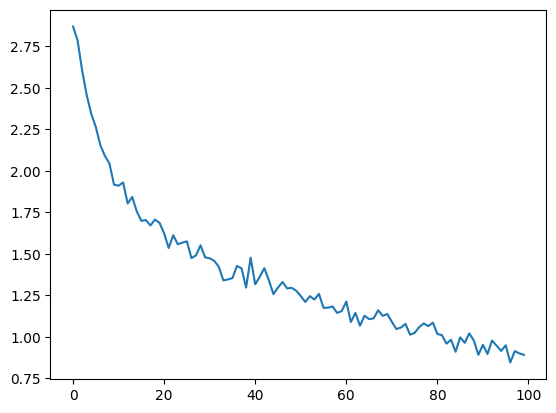

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
#As we can see the plot as trend to decrease over time, this is due the model perfomance improving
#meaning less mistakes are  being done/Algorithm is learning

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


<ipython-input-20-1c4b9dd31c42>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-1c4b9dd31c42>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


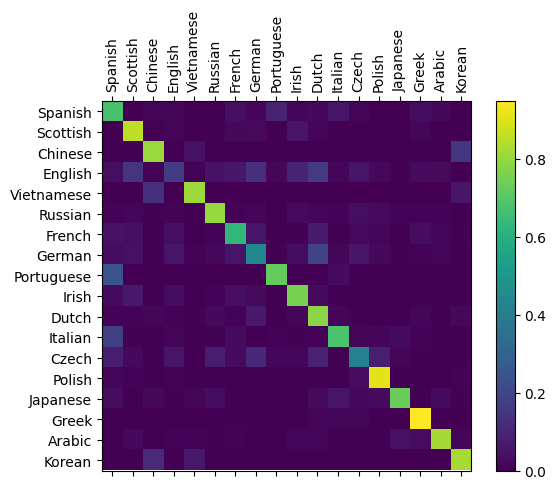

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

############

#The confusion matrix shows how well did the model predict that a name belonged to certein category
#It seems to work the best with Vietnamese and Arab names. While it seems to struggle only with English.


You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [21]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Rivera')
predict('Mirzoodilov')
predict('Noßol')
predict('Jägger')


> Dovesky
(-0.66) Russian
(-1.01) Czech
(-2.50) English

> Jackson
(-0.05) Scottish
(-3.32) English
(-5.15) Russian

> Satoshi
(-0.51) Japanese
(-1.97) Italian
(-2.41) Czech

> Rivera
(-0.17) Spanish
(-2.05) Italian
(-4.57) Dutch

> Mirzoodilov
(-0.30) Russian
(-1.56) Polish
(-3.29) Czech

> Noßol
(-0.88) Spanish
(-1.10) Polish
(-2.38) Czech

> Jägger
(-1.18) German
(-1.28) Czech
(-1.48) English


The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)
split the above code into a few files:

-   `data.py` (loads files)
-   `model.py` (defines the RNN)
-   `train.py` (runs training)
-   `predict.py` (runs `predict()` with command line arguments)
-   `server.py` (serve prediction as a JSON API with `bottle.py`)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions:

``` {.sh}
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit <http://localhost:5533/Yourname> to get JSON
output of predictions.


Exercises
=========
- 7.1 a\) Comments to the code and plots where done in code using #.

- b\)**Pros:**  A RNN for characters from the  seems to be a great approach for name classification. After all names of diferent regions tend to follow a similar gramatic and orgin, which must leave some hidden patterns.

  Thanks to the transformation of the names into ASCII code, the each character could be differentiated from each other.

  Using backpropagation in the training loop, the model is able to learn, allowing the algorithm to catch the hidden patterns critical for the name classification. This improvement is visualized by monitoring the output of the loss function over time.

- **Contras:**On the other hand the transformation of to ASCII, doesnt collect special symbols which could hint further the classification of the name, losing some data by simplying. And, while this was done for short data sets, in the future it might need enhancement layers or regularization techniques if larges data sets are used. It also lacks of memory during the sequential processing (meachinism to decide when to remember or forgent certain hidden states)



########################################

-   Try with a different dataset of line -\> category, for example:
    -   Any word -\> language
    -   First name -\> gender
    -   Character name -\> writer
    -   Page title -\> blog or subreddit
-   Get better results with a bigger and/or better shaped network
    -   Add more linear layers
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network


**7.2 a\)**

In [22]:
# Flatten the dictionary "category_lines" into X (names) and y (categories)
X = []  # List of names (inputs)
y = []  # List of categories (labels)

for category, names in category_lines.items():
    X.extend(names)  # Add all names to X
    y.extend([category] * len(names))  # Add the corresponding category to y

print(f"Number of samples: {len(X)}")
print(f"Examples of X: {X[5:]}")  # After the 5 names
print(f"Examples of y: {y[5:]}")  # Corresponding categories


Number of samples: 20074
Examples of X: ['Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua', 'Aquino', 'Araujo', 'Araullo', 'Araya', 'Arce', 'Arechavaleta', 'Arena', 'Aritza', 'Armando', 'Arreola', 'Arriola', 'Asis', 'Asturias', 'Avana', 'Azarola', 'Banderas', 'Barros', 'Basurto', 'Bautista', 'Bello', 'Belmonte', 'Bengochea', 'Benitez', 'Bermudez', 'Blanco', 'Blanxart', 'Bolivar', 'Bonaventura', 'Bosque', 'Bustillo', 'Busto', 'Bustos', 'Cabello', 'Cabrera', 'Campo', 'Campos', 'Capello', 'Cardona', 'Caro', 'Casales', 'Castell', 'Castellano', 'Castillion', 'Castillo', 'Castro', 'Chavarria', 'Chavez', 'Colon', 'Costa', 'Crespo', 'Cruz', 'Cuellar', 'Cuevas', "D'cruz", "D'cruze", 'De la cruz', 'De la fuente', 'Del bosque', 'De leon', 'Delgado', 'Del olmo', 'De santigo', 'Diaz', 'Dominguez', 'Duarte', 'Durante', 'Echevarria', 'Echeverria

In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
len(X_train), len(X_test), len(y_train), len(y_test)

Training samples: 16059
Testing samples: 4015


(16059, 4015, 16059, 4015)

In [24]:
def randomTrainingExample():
    import random
    i = random.randint(0, len(X_train) - 1)
    line = X_train[i]
    category = y_train[i]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [25]:
import time
import math

# Function to evaluate accuracy on test set
def evaluate():
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
            line_tensor = lineToTensor(line)

            hidden = rnn.initHidden()
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Set parameters
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Training function
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Start training
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print progress
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        test_accuracy = evaluate()
        print('%d %d%% (%s) Loss: %.4f | Test Accuracy: %.2f%% | %s / %s %s' %
              (iter, iter / n_iters * 100, timeSince(start), loss, test_accuracy * 100, line, guess, correct))

    # Plot losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


    #It seems that the model get an accuracy average of ~77% after the firs 5 runs
    #The training data was splited into 20 percent training and 80 percent test


5000 5% (0m 11s) Loss: 0.0034 | Test Accuracy: 74.72% | Zinov / Russian ✓
10000 10% (0m 23s) Loss: 0.0080 | Test Accuracy: 75.97% | BeknazarYuzbashev / Russian ✓
15000 15% (0m 34s) Loss: 0.8980 | Test Accuracy: 75.04% | Tassioglou / Greek ✓
20000 20% (0m 46s) Loss: 1.1988 | Test Accuracy: 76.39% | Verney / Russian ✗ (English)
25000 25% (0m 57s) Loss: 0.9342 | Test Accuracy: 75.37% | Baumgarten / Russian ✓
30000 30% (1m 9s) Loss: 0.0280 | Test Accuracy: 75.74% | Lutov / Russian ✓
35000 35% (1m 20s) Loss: 3.8292 | Test Accuracy: 75.77% | Silva / Polish ✗ (Portuguese)
40000 40% (1m 31s) Loss: 1.2440 | Test Accuracy: 75.74% | Horn / English ✗ (German)
45000 45% (1m 43s) Loss: 0.3549 | Test Accuracy: 76.61% | Bernard / English ✓
50000 50% (1m 55s) Loss: 3.6235 | Test Accuracy: 74.65% | Tykal / Russian ✗ (Czech)
55000 55% (2m 7s) Loss: 0.0022 | Test Accuracy: 77.38% | Anisikhin / Russian ✓
60000 60% (2m 18s) Loss: 0.2177 | Test Accuracy: 76.96% | Avdiyants / Russian ✓
65000 65% (2m 30s) Loss

**b\)**

In [31]:
import torch
import time
import math

# Function to evaluate accuracy on test set
def evaluate():
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
            line_tensor = lineToTensor(line).to(device)  # Move to device

            hidden = rnn.initHidden().to(device)  # Move hidden state to device
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Set parameters
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Training function
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)  # Move hidden state to device
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Move model to device (GPU if available)
rnn.to(device)

# Start timer
start = time.time()

# Training loop on GPU
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor = category_tensor.to(device)  # Move category tensor to device
    line_tensor = line_tensor.to(device)  # Move line tensor to device
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print progress
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        test_accuracy = evaluate()
        print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

    # Plot losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Total training time on GPU
total_time_gpu = time.time() - start
print(f"Training time on GPU: {total_time_gpu:.2f} seconds")




Training on cuda
5000 5.00% (0m 22s) Loss: 0.0019 | Test Accuracy: 77.24% | Alshevsky / Russian ✓
10000 10.00% (0m 45s) Loss: 0.0511 | Test Accuracy: 76.24% | Ashford / English ✓
15000 15.00% (1m 11s) Loss: 0.0382 | Test Accuracy: 76.49% | Ellard / English ✓
20000 20.00% (1m 33s) Loss: 0.2341 | Test Accuracy: 76.64% | Santo / Japanese ✓
25000 25.00% (1m 55s) Loss: 0.5780 | Test Accuracy: 77.19% | Geiszler / German ✓
30000 30.00% (2m 18s) Loss: 0.1014 | Test Accuracy: 78.53% | Mukin / Russian ✓
35000 35.00% (2m 41s) Loss: 0.0005 | Test Accuracy: 77.38% | Tujikov / Russian ✓
40000 40.00% (3m 4s) Loss: 0.0095 | Test Accuracy: 76.59% | Iijima / Japanese ✓
45000 45.00% (3m 26s) Loss: 0.5007 | Test Accuracy: 78.43% | Fisun / Russian ✓
50000 50.00% (3m 49s) Loss: 0.0250 | Test Accuracy: 77.29% | Woollard / English ✓
55000 55.00% (4m 11s) Loss: 0.0019 | Test Accuracy: 75.62% | Mikhail / Arabic ✓
60000 60.00% (4m 34s) Loss: 0.0001 | Test Accuracy: 76.89% | Jakunkin / Russian ✓
65000 65.00% (4m 

In [32]:
import torch
import time
import math

# Function to evaluate accuracy on test set
def evaluate():
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
            line_tensor = lineToTensor(line).to(device)  # Move to device

            hidden = rnn.initHidden().to(device)  # Move hidden state to device
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Set parameters
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Training function
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)  # Move hidden state to device
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Use CPU
device = torch.device("cpu")
print(f"Training on {device}")

# Move model to CPU
rnn.to(device)

# Start timer
start = time.time()

# Training loop on CPU
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor = category_tensor.to(device)  # Move category tensor to device
    line_tensor = line_tensor.to(device)  # Move line tensor to device
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print progress
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        test_accuracy = evaluate()
        print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

    # Plot losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Total training time on CPU
total_time_cpu = time.time() - start
print(f"Training time on CPU: {total_time_cpu:.2f} seconds")


Training on cpu
5000 5.00% (0m 12s) Loss: 3.9479 | Test Accuracy: 76.36% | De leon / English ✗ (Spanish)
10000 10.00% (0m 24s) Loss: 3.2409 | Test Accuracy: 77.01% | Jippensha / Russian ✗ (Japanese)
15000 15.00% (0m 36s) Loss: 3.8297 | Test Accuracy: 76.79% | Petersen / German ✗ (Czech)
20000 20.00% (0m 48s) Loss: 0.0004 | Test Accuracy: 78.06% | Halatov / Russian ✓
25000 25.00% (1m 0s) Loss: 0.0172 | Test Accuracy: 77.21% | Kalitvin / Russian ✓
30000 30.00% (1m 14s) Loss: 1.1773 | Test Accuracy: 76.79% | Harker / German ✗ (English)
35000 35.00% (1m 26s) Loss: 0.0004 | Test Accuracy: 76.86% | Durmanov / Russian ✓
40000 40.00% (1m 38s) Loss: 0.0064 | Test Accuracy: 75.94% | O'Neal / Irish ✓
45000 45.00% (1m 50s) Loss: 0.0133 | Test Accuracy: 76.76% | Ustvolsky / Russian ✓
50000 50.00% (2m 2s) Loss: 0.5215 | Test Accuracy: 77.11% | Nifterick / Dutch ✓
55000 55.00% (2m 13s) Loss: 2.1146 | Test Accuracy: 77.16% | Wright / English ✗ (Scottish)
60000 60.00% (2m 25s) Loss: 0.0369 | Test Accur

Surprisingly the CPU had better runtime with 242.31 seconds for the training compared to 455.19 seconds it needed while using the GPU (T4 from Google Colab)

**c\)**

In [38]:
# Set parameters
n_hidden = 512  # Fourtimes of 128
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Define function to train and evaluate the model
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Function to evaluate accuracy on test set
def evaluate():
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
            line_tensor = lineToTensor(line)

            hidden = rnn.initHidden()
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Start training with the defined hidden size
start = time.time()

# Initialize RNN with the new hidden size
rnn = RNN(n_letters, n_hidden, n_categories)

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print progress
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        test_accuracy = evaluate()
        print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

    # Plot losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Total training time
total_time = time.time() - start
print(f"Training time with {n_hidden} hidden units: {total_time:.2f} seconds")


5000 5.00% (0m 25s) Loss: 0.6896 | Test Accuracy: 65.33% | Ferris / English ✓
10000 10.00% (0m 50s) Loss: 2.8409 | Test Accuracy: 61.89% | Selmone / English ✗ (Italian)
15000 15.00% (1m 16s) Loss: 0.8208 | Test Accuracy: 64.81% | Tolley / English ✓
20000 20.00% (1m 41s) Loss: 0.0007 | Test Accuracy: 70.54% | Nesmeyanov / Russian ✓
25000 25.00% (2m 8s) Loss: 0.1871 | Test Accuracy: 69.86% | Attia / Arabic ✓
30000 30.00% (2m 36s) Loss: 0.0057 | Test Accuracy: 72.40% | Valtchikovsky / Russian ✓
35000 35.00% (3m 5s) Loss: 0.6716 | Test Accuracy: 71.96% | Liddell / English ✓
40000 40.00% (3m 34s) Loss: 0.8589 | Test Accuracy: 73.05% | Parma / Italian ✓
45000 45.00% (4m 3s) Loss: 1.9204 | Test Accuracy: 65.01% | Froman / English ✗ (Russian)
50000 50.00% (4m 31s) Loss: 3.3679 | Test Accuracy: 70.29% | Tamboia / Japanese ✗ (Italian)
55000 55.00% (5m 6s) Loss: 0.7860 | Test Accuracy: 73.57% | Drechsler / German ✓
60000 60.00% (5m 33s) Loss: 0.4241 | Test Accuracy: 73.10% | Bologna / Italian ✓
6

In [36]:


# Set parameters
n_hidden = 256  # Double of 128
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Define function to train and evaluate the model
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Function to evaluate accuracy on test set
def evaluate():
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
            line_tensor = lineToTensor(line)

            hidden = rnn.initHidden()
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Start training with the defined hidden size
start = time.time()

# Initialize RNN with the new hidden size
rnn = RNN(n_letters, n_hidden, n_categories)

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print progress
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        test_accuracy = evaluate()
        print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

    # Plot losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Total training time
total_time = time.time() - start
print(f"Training time with {n_hidden} hidden units: {total_time:.2f} seconds")


5000 5.00% (0m 14s) Loss: 0.0964 | Test Accuracy: 63.59% | Zaslavsky / Russian ✓
10000 10.00% (0m 30s) Loss: 0.1652 | Test Accuracy: 65.11% | Zhovtyak / Russian ✓
15000 15.00% (0m 44s) Loss: 0.0863 | Test Accuracy: 68.59% | Nezhlukto / Russian ✓
20000 20.00% (0m 58s) Loss: 2.8927 | Test Accuracy: 71.16% | Gammer / Arabic ✗ (English)
25000 25.00% (1m 12s) Loss: 0.0083 | Test Accuracy: 71.08% | Yakushkin / Russian ✓
30000 30.00% (1m 27s) Loss: 0.0089 | Test Accuracy: 71.11% | Jafarov / Russian ✓
35000 35.00% (1m 42s) Loss: 0.0287 | Test Accuracy: 72.18% | Abramtchuk / Russian ✓
40000 40.00% (1m 56s) Loss: 0.9096 | Test Accuracy: 68.04% | VanPuteren / English ✗ (Russian)
45000 45.00% (2m 15s) Loss: 0.3954 | Test Accuracy: 72.78% | Mihlin / Russian ✓
50000 50.00% (2m 29s) Loss: 0.1025 | Test Accuracy: 73.25% | Mohosoev / Russian ✓
55000 55.00% (2m 43s) Loss: 0.0002 | Test Accuracy: 71.01% | Jdankov / Russian ✓
60000 60.00% (2m 57s) Loss: 1.1110 | Test Accuracy: 72.73% | Maynard / Arabic ✗ 

In [37]:
# Set parameters
n_hidden = 64  # Half of 128
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Define function to train and evaluate the model
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Function to evaluate accuracy on test set
def evaluate():
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
            line_tensor = lineToTensor(line)

            hidden = rnn.initHidden()
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Start training with the defined hidden size
start = time.time()

# Initialize RNN with the new hidden size
rnn = RNN(n_letters, n_hidden, n_categories)

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print progress
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        test_accuracy = evaluate()
        print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

    # Plot losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Total training time
total_time = time.time() - start
print(f"Training time with {n_hidden} hidden units: {total_time:.2f} seconds")

5000 5.00% (0m 11s) Loss: 1.3876 | Test Accuracy: 56.19% | Elven / Russian ✗ (English)
10000 10.00% (0m 22s) Loss: 0.0217 | Test Accuracy: 59.48% | Pechatkin / Russian ✓
15000 15.00% (0m 34s) Loss: 0.6410 | Test Accuracy: 68.17% | Kumasaka / Japanese ✓
20000 20.00% (0m 47s) Loss: 0.5448 | Test Accuracy: 67.07% | Jakush / Russian ✓
25000 25.00% (1m 1s) Loss: 0.4399 | Test Accuracy: 70.56% | Alford / English ✓
30000 30.00% (1m 14s) Loss: 1.3042 | Test Accuracy: 68.89% | Handal / English ✗ (Arabic)
35000 35.00% (1m 26s) Loss: 0.4850 | Test Accuracy: 70.73% | Koury / Arabic ✓
40000 40.00% (1m 38s) Loss: 0.5967 | Test Accuracy: 71.43% | Arian / Arabic ✓
45000 45.00% (1m 50s) Loss: 0.0092 | Test Accuracy: 72.60% | Tzalykhin / Russian ✓
50000 50.00% (2m 2s) Loss: 0.1429 | Test Accuracy: 73.45% | Hudik / Russian ✓
55000 55.00% (2m 16s) Loss: 1.6039 | Test Accuracy: 74.40% | Ventura / Italian ✓
60000 60.00% (2m 31s) Loss: 0.0912 | Test Accuracy: 73.08% | Kalinovich / Russian ✓
65000 65.00% (2m 

The hidden layer size comparison is:

- 64: reaches ~76 percent accuracy
- 128: reaches ~77 percent accuracy
- 256: reaches ~74 percent accuracy
- 512: reaches ~72 percent accuracy

From all the tests it seems tha 128 hidden layer size was the bets approach, all the other multiple for chunks calculation, result in a worse accuracy. This means that an optimal size must be around 128.

**d\)**

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LSTM Model
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_Model, self).__init__()

        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)

        # Output layer
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        out, (hidden, cell) = self.lstm(input.view(1, 1, -1), hidden)
        output = self.h2o(out.view(1, -1))
        output = self.softmax(output)
        return output, (hidden, cell)

    def initHidden(self):
        # Initialize hidden and cell state as zeros for LSTM
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))


# GRU Model
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_Model, self).__init__()

        self.hidden_size = hidden_size

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size)

        # Output layer
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        out, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.h2o(out.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Initialize hidden state as zeros for GRU
        return torch.zeros(1, 1, self.hidden_size)


In [44]:
import time
import math
import torch
import random
import string

# Function to evaluate accuracy on test set
def evaluate(rnn, X_test, y_test, all_categories):
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
            line_tensor = lineToTensor(line)

            hidden = rnn.initHidden()
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Time helper function
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Set parameters
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005

# Training function
def train(rnn, category_tensor, line_tensor, criterion):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Main training loop
def train_and_evaluate_with_model(rnn, n_iters, print_every, plot_every, criterion, X_test, y_test, all_categories):
    start = time.time()
    current_loss = 0
    all_losses = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()  # Define this function
        output, loss = train(rnn, category_tensor, line_tensor, criterion)
        current_loss += loss

        # Print progress
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            test_accuracy = evaluate(rnn, X_test, y_test, all_categories)
            print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

        # Plot losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

# Initialize models and evaluate
def run_model_evaluation():
    # Use CPU device
    device = torch.device("cpu")
    print(f"Training on {device}")

    # Initialize the models (LSTM and GRU) and define the loss function
    criterion = nn.NLLLoss()

    # LSTM
    lstm_model = LSTM_Model(n_letters, 256, n_categories).to(device)
    print("Training LSTM Model...")
    train_and_evaluate_with_model(lstm_model, n_iters, print_every, plot_every, criterion, X_test, y_test, all_categories)

    # GRU
    gru_model = GRU_Model(n_letters, 256, n_categories).to(device)
    print("\nTraining GRU Model...")
    train_and_evaluate_with_model(gru_model, n_iters, print_every, plot_every, criterion, X_test, y_test, all_categories)

# Start model evaluation
run_model_evaluation()



Training on cpu
Training LSTM Model...
5000 5.00% (1m 12s) Loss: 0.7635 | Test Accuracy: 46.92% | Poretsky / Russian ✓
10000 10.00% (2m 22s) Loss: 0.4476 | Test Accuracy: 50.59% | Isachenko / Russian ✓
15000 15.00% (3m 35s) Loss: 2.8927 | Test Accuracy: 52.40% | Por / English ✗ (Russian)
20000 20.00% (4m 46s) Loss: 4.7764 | Test Accuracy: 58.53% | Mckay / Russian ✗ (Scottish)
25000 25.00% (5m 58s) Loss: 1.0788 | Test Accuracy: 59.58% | Nahas / Arabic ✓
30000 30.00% (7m 11s) Loss: 3.5862 | Test Accuracy: 59.80% | Foss / Arabic ✗ (French)
35000 35.00% (8m 25s) Loss: 3.9018 | Test Accuracy: 60.85% | Manos / Arabic ✗ (Greek)
40000 40.00% (9m 36s) Loss: 4.0898 | Test Accuracy: 61.87% | Durante / English ✗ (Spanish)
45000 45.00% (10m 50s) Loss: 0.7107 | Test Accuracy: 62.89% | Amari / Arabic ✓
50000 50.00% (12m 0s) Loss: 0.0004 | Test Accuracy: 63.14% | Abubekerov / Russian ✓
55000 55.00% (13m 12s) Loss: 2.8080 | Test Accuracy: 65.85% | Janca / English ✗ (Czech)
60000 60.00% (14m 24s) Loss: 

The use of a LSTM or GRU Model show a constant increase of model performance in comparison with evaluation of RNN. But the RNN model still perfoms better than both of these alternatives, this might relay on HyperparameterTuning, or on the case of the data base not being large enough.


**e\)**

In [50]:
# Force everything to run on CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# Training function for a specific optimizer
def train_with_optimizer(optimizer, category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)  # Ensure hidden is on CPU
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()  # Update model parameters
    return output, loss.item()

# Function to train and evaluate the model using different optimizers
def run_training_and_evaluation():
    optimizer_classes = {
        'SGD': torch.optim.SGD,
        'Adam': torch.optim.Adam,
        'RMSprop': torch.optim.RMSprop
    }

    for optimizer_name, optimizer_class in optimizer_classes.items():
        print(f"\nTraining with {optimizer_name} optimizer...")

        # Initialize the model and optimizer
        rnn = RNN(n_letters, 128, n_categories).to(device)  # Hidden layer size of 128, model moved to CPU
        optimizer = optimizer_class(rnn.parameters(), lr=learning_rate)

        # Start training
        start = time.time()
        current_loss = 0
        all_losses = []

        for iter in range(1, n_iters + 1):
            category, line, category_tensor, line_tensor = randomTrainingExample()
            category_tensor = category_tensor.to(device)  # Move to CPU
            line_tensor = line_tensor.to(device)  # Move to CPU
            output, loss = train_with_optimizer(optimizer, category_tensor, line_tensor)
            current_loss += loss

            # Print progress
            if iter % print_every == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                test_accuracy = evaluate(rnn)  # Ensure evaluate uses the correct rnn
                print(f'{iter} {iter / n_iters * 100:.2f}% ({timeSince(start)}) Loss: {loss:.4f} | '
                      f'Test Accuracy: {test_accuracy * 100:.2f}% | {line} / {guess} {correct}')

            # Plot losses
            if iter % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0

        total_time = time.time() - start
        print(f"Training time with {optimizer_name}: {total_time:.2f} seconds\n")

# Ensure evaluate() works with the provided rnn
def evaluate(rnn):
    rnn.eval()
    correct = 0
    total = len(X_test)
    with torch.no_grad():
        for i in range(total):
            line = X_test[i]
            category = y_test[i]
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
            line_tensor = lineToTensor(line).to(device)

            hidden = rnn.initHidden().to(device)
            for j in range(line_tensor.size()[0]):
                output, hidden = rnn(line_tensor[j], hidden)

            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                correct += 1
    return correct / total

# Call the function to run training and evaluation for all optimizers
run_training_and_evaluation()




Using device: cpu

Training with SGD optimizer...
5000 5.00% (0m 25s) Loss: 0.7136 | Test Accuracy: 8.00% | Kempster / English ✓
10000 10.00% (0m 49s) Loss: 0.8980 | Test Accuracy: 8.00% | Shinko / Russian ✗ (Japanese)
15000 15.00% (1m 14s) Loss: 0.0083 | Test Accuracy: 8.00% | Serejnikov / Russian ✓
20000 20.00% (1m 39s) Loss: 0.0090 | Test Accuracy: 8.00% | Agaloff / Russian ✓
25000 25.00% (2m 5s) Loss: 1.9954 | Test Accuracy: 8.00% | Li / Italian ✗ (Russian)
30000 30.00% (2m 30s) Loss: 0.4354 | Test Accuracy: 8.00% | Watanabe / Japanese ✓
35000 35.00% (2m 55s) Loss: 0.0027 | Test Accuracy: 8.00% | Marhanov / Russian ✓
40000 40.00% (3m 19s) Loss: 0.0706 | Test Accuracy: 8.00% | Hamraev / Russian ✓
45000 45.00% (3m 43s) Loss: 1.6406 | Test Accuracy: 8.00% | Lagomarsino / Japanese ✗ (Italian)
50000 50.00% (4m 8s) Loss: 0.6394 | Test Accuracy: 8.00% | Astbury / English ✓
55000 55.00% (4m 32s) Loss: 0.2316 | Test Accuracy: 8.00% | Ganim / Arabic ✓
60000 60.00% (4m 57s) Loss: 2.4075 | Tes

The Model should have more confidence on the classification of the name, the longer the name is, as the model would have more data to process through the hidden layers, which results in more precise predictions.

The network is generally more confident in correct classifications, as the probability for the correct class is higher, while in incorrect classifications, the confidence (probability) is usually lower.

All the current optimizers are possible alternatives but there seems to be a problem at the moment of updating the model as the accuracy never changed during the whole evaluation, but must lay down on the code.

According to Internet forums, adam should be the best optimizer compared to the other ones, while SDG is the most basic and the default one.

